# **`NLP` : Natural Language Processing**
#### Title: **Sequence (or PoS: Part-of-Speech) Tagging with `PyTorch` (or `Torch`)**

##### Author: **`Bilal KACEL`**
##### Version: 1.0.0

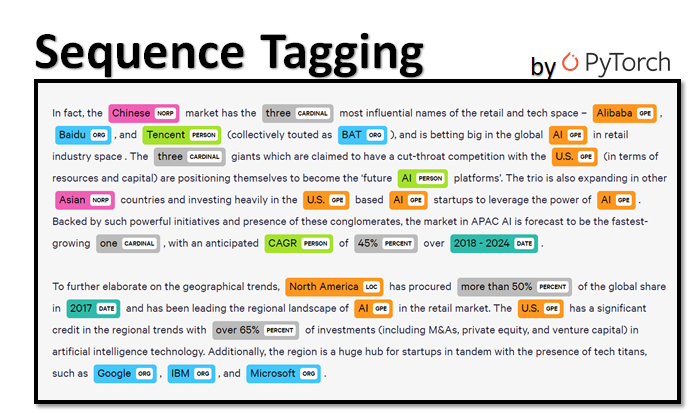

# **Partie 1**: **A First Toy** (Simple Dataset)

## **1) Import des Dépendances**

In [ ]:
import pickle # for the real data 
import torch  # Torch + shortcuts
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1) # To reproduce the experiments

## **2) Training set**

In [ ]:
training_data =[("The dog ate the apple".split(), ["DET", "NOUN", "VERB", "DET", "NOUN"]),
 ("Everybody read that book".split(), ["NOUN", "VERB", "DET", "NOUN"]),
 (['The','Fulton','County','Grand','Jury','said','Friday','an','investigation','of',"Atlanta's",'recent','primary','election','produced','``','no','evidence','','that','any','irregularities','took','place','.'],['DET','NOUN','NOUN','ADJ','NOUN','VERB','NOUN','DET','NOUN','ADP','NOUN','ADJ','NOUN','NOUN','VERB','.','DET','NOUN','.','ADP','DET','NOUN','VERB','NOUN','.']),
 (['The','jury','further','said','in','term-end','presentments','that','the','City','Executive','Committee',',','which','had','over-all','charge','of','the','election',',','``','deserves','the','praise','and','thanks','of','the','City','of','Atlanta','','for','the','manner','in','which','the','election','was','conducted','.'],['DET','NOUN','ADV','VERB','ADP','NOUN','NOUN','ADP','DET','NOUN','ADJ','NOUN','.','DET','VERB','ADJ','NOUN','ADP','DET','NOUN','.','.','VERB','DET','NOUN','CONJ','NOUN','ADP','DET','NOUN','ADP','NOUN','.','ADP','DET','NOUN','ADP','DET','DET','NOUN','VERB','VERB','.']),
 (['The','September-October','term','jury','had','been','charged','by','Fulton','Superior','Court','Judge','Durwood','Pye','to','investigate','reports','of','possible','``','irregularities','','in','the','hard-fought','primary','which','was','won','by','Mayor-nominate','Ivan','Allen','Jr.','.'],['DET','NOUN','NOUN','NOUN','VERB','VERB','VERB','ADP','NOUN','ADJ','NOUN','NOUN','NOUN','NOUN','PRT','VERB','NOUN','ADP','ADJ','.','NOUN','.','ADP','DET','ADJ','NOUN','DET','VERB','VERB','ADP','NOUN','NOUN','NOUN','NOUN','.']),
 (['``','Only','a','relative','handful','of','such','reports','was','received','',',','the','jury','said',',','``','considering','the','widespread','interest','in','the','election',',','the','number','of','voters','and','the','size','of','this','city','','.'],['.','ADV','DET','ADJ','NOUN','ADP','ADJ','NOUN','VERB','VERB','.','.','DET','NOUN','VERB','.','.','ADP','DET','ADJ','NOUN','ADP','DET','NOUN','.','DET','NOUN','ADP','NOUN','CONJ','DET','NOUN','ADP','DET','NOUN','.','.']),
 (['The','jury','said','it','did','find','that','many','of',"Georgia's",'registration','and','election','laws','``','are','outmoded','or','inadequate','and','often','ambiguous','','.'],['DET','NOUN','VERB','PRON','VERB','VERB','ADP','ADJ','ADP','NOUN','NOUN','CONJ','NOUN','NOUN','.','VERB','ADJ','CONJ','ADJ','CONJ','ADV','ADJ','.','.']),
 (['It','recommended','that','Fulton','legislators','act','``','to','have','these','laws','studied','and','revised','to','the','end','of','modernizing','and','improving','them','','.'],['PRON','VERB','ADP','NOUN','NOUN','VERB','.','PRT','VERB','DET','NOUN','VERB','CONJ','VERB','ADP','DET','NOUN','ADP','VERB','CONJ','VERB','PRON','.','.']),
 (['The','grand','jury','commented','on','a','number','of','other','topics',',','among','them','the','Atlanta','and','Fulton','County','purchasing','departments','which','it','said','``','are','well','operated','and','follow','generally','accepted','practices','which','inure','to','the','best','interest','of','both','governments','','.'],['DET','ADJ','NOUN','VERB','ADP','DET','NOUN','ADP','ADJ','NOUN','.','ADP','PRON','DET','NOUN','CONJ','NOUN','NOUN','VERB','NOUN','DET','PRON','VERB','.','VERB','ADV','VERB','CONJ','VERB','ADV','VERB','NOUN','DET','VERB','ADP','DET','ADJ','NOUN','ADP','DET','NOUN','.','.']),
 (['Merger', 'proposed'], ['NOUN', 'VERB']),
 (['However',',','the','jury','said','it','believes','``','these','two','offices','should','be','combined','to','achieve','greater','efficiency','and','reduce','the','cost','of','administration','','.'],['ADV','.','DET','NOUN','VERB','PRON','VERB','.','DET','NUM','NOUN','VERB','VERB','VERB','PRT','VERB','ADJ','NOUN','CONJ','VERB','DET','NOUN','ADP','NOUN','.','.']),
 (['The','City','Purchasing','Department',',','the','jury','said',',','``','is','lacking','in','experienced','clerical','personnel','as','a','result','of','city','personnel','policies','','.'],['DET','NOUN','VERB','NOUN','.','DET','NOUN','VERB','.','.','VERB','VERB','ADP','VERB','ADJ','NOUN','ADP','DET','NOUN','ADP','NOUN','NOUN','NOUN','.','.'])
]


## **3) Data Prep + Vocabularies building**

In [ ]:
# Convert the input sequence into an integer one.
# The mapping is recorded in the dictionnary to_ix
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return tensor

# Toy dataset
"""
training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
"""

# The dictionnary : word -> index
word_to_ix = {}

# The other : tag -> index
tag_to_ix = {}

# Build them (dictionnaires: Vocabulaires, Tags)
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)
##
print("Words dict: ", word_to_ix)
print("Tags  dict: ", tag_to_ix)

print("The sentence : ", training_data[0][0])
print("The tag seq. : ", training_data[0][1])
print("#### in the prepared version")
print("The sentence : ", prepare_sequence(training_data[0][0], word_to_ix))
print("The tag seq. : ", prepare_sequence(training_data[0][1], tag_to_ix))

Words dict:  {'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8, 'Fulton': 9, 'County': 10, 'Grand': 11, 'Jury': 12, 'said': 13, 'Friday': 14, 'an': 15, 'investigation': 16, 'of': 17, "Atlanta's": 18, 'recent': 19, 'primary': 20, 'election': 21, 'produced': 22, '``': 23, 'no': 24, 'evidence': 25, '': 26, 'any': 27, 'irregularities': 28, 'took': 29, 'place': 30, '.': 31, 'jury': 32, 'further': 33, 'in': 34, 'term-end': 35, 'presentments': 36, 'City': 37, 'Executive': 38, 'Committee': 39, ',': 40, 'which': 41, 'had': 42, 'over-all': 43, 'charge': 44, 'deserves': 45, 'praise': 46, 'and': 47, 'thanks': 48, 'Atlanta': 49, 'for': 50, 'manner': 51, 'was': 52, 'conducted': 53, 'September-October': 54, 'term': 55, 'been': 56, 'charged': 57, 'by': 58, 'Superior': 59, 'Court': 60, 'Judge': 61, 'Durwood': 62, 'Pye': 63, 'to': 64, 'investigate': 65, 'reports': 66, 'possible': 67, 'hard-fought': 68, 'won': 69, 'Mayor-nominate': 70, 'Ivan': 71, 'Allen

## **4) Neural Network**

In [ ]:
class RecurrentTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(RecurrentTagger, self).__init__()

        self.hidden_dim = hidden_dim # Dimension de la Hidden Layer
        self.word_embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim) # Couche Embedding

        self.lstm = nn.LSTM(embedding_dim, hidden_dim) # Couche LSTM

        self.out = nn.Linear(hidden_dim, tagset_size) # Couche Linéaire associant Hidden State à espace de Tag

        self.hn = self.init_hidden() # initialisation de Hidden State


    def init_hidden(self):
        # This function is given: understand it.

        # Les poids ont la forme: (nb_layers, batch_size, hidden_dim)
        return (torch.zeros(1, 1, self.hidden_dim), torch.zeros(1, 1, self.hidden_dim))


    def forward(self, sentence):
      # Your work

      #print("==== FORWARD ====")
      #print("sentence.shape", sentence.shape)

      embs = self.word_embeddings(sentence) # Création des vecteurs Embeddings
      #print("embs.shape", embs.shape)

      lstm_out, self.hn = self.lstm(embs.view(len(sentence), 1, -1), self.hn) # Récupérer les sorties de la LSTM
      #print("lstm_out.shape", lstm_out.shape)

      tag_outputs = self.out(lstm_out.view(len(sentence), -1)) # 
      #print("tag_outputs.shape", tag_outputs.shape)

      tag_scores = F.log_softmax(tag_outputs, dim=1) # 
      #print("tag_scores.shape", tag_scores.shape)

      #print("==============")

      return tag_scores

## **5) Entraînement**

In [ ]:
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

n_epochs = 300
accuracy_list = []
loss_list = []

# Initialisation du modèle
model = RecurrentTagger(
    embedding_dim=EMBEDDING_DIM, 
    hidden_dim=HIDDEN_DIM, 
    vocab_size=len(word_to_ix), 
    tagset_size=len(tag_to_ix))


# Calcul sur GPU si disponible
"""
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    model.cuda() # Envoi du modèle sur GPU
"""

loss_function = nn.NLLLoss() # Définition de la fonction de Loss
optimizer = optim.SGD(model.parameters(), lr=0.1) # Définition de l'Optimiseur

# Look at the scores 
# The output element i,j concerns the  tag j pour le mot i.
"""
inputs = prepare_sequence(training_data[0][0], word_to_ix)
tag_scores = model(inputs)
print(tag_scores)
"""


print("Vocab Size:", len(word_to_ix))
print("Tags Size:", len(tag_to_ix))


print("Début Training ...")
for epoch in range(n_epochs):  # again, normally you would NOT do 300 epochs, it is toy data

    epoch_loss = 0.0
    epoch_accuracy = 0.0
    correct = 0
    total = 0

    for sentence, tags in training_data:

        # Get our inputs ready for the network
        sentence_input = prepare_sequence(sentence, word_to_ix) #.to(device)
        tags_labels = prepare_sequence(tags, tag_to_ix) #.to(device)

        #print("\t sentence_input.shape:", sentence_input.shape)
        #print("\t tags_labels.shape:", tags_labels.shape)

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step2: Also, we need to clear out the hidden state of the recurrent net,
        # detaching it from its history on the last instance.
        model.hn = model.init_hidden()

        

        # Step 3. Run our forward pass.
        tags_scores = model(sentence_input)
        #print("\t tags_scores.shape:", tags_scores.shape)

        #print(tags_scores)
        #break

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tags_scores, tags_labels) # Calcul de la Loss
        
        #print("\t loss.shape:", loss.shape)

        epoch_loss += loss.item()
        _, predicted = torch.max(tags_scores, 1)

        #print("\t predicted.shape:", predicted.shape)

        total += tags_labels.size(0)
        correct = (predicted == tags_labels).sum().item()
        epoch_accuracy += correct

        loss.backward() # Calcul des gradients
        optimizer.step() # Mise à jour des poids

    loss_list.append(float( epoch_loss ))
    accuracy_list.append(float( epoch_accuracy/total ))

    if (epoch + 1) % 10 == 0 :
      epoch_accuracy = epoch_accuracy/total
      print("\t Epoch "+ str(epoch + 1) +"/"+str(n_epochs), "\t Loss:", epoch_loss, "\t Accuracy:", epoch_accuracy)

print("Training terminé")


# Les mêmes scores à la fin
"""
inputs = prepare_sequence(training_data[0][0], word_to_ix)
tag_scores = model(inputs)
print(tag_scores)
"""

Vocab Size: 156
Tags Size: 11
Début Training ...
	 Epoch 10/300 	 Loss: 22.930586576461792 	 Accuracy: 0.2901023890784983
	 Epoch 20/300 	 Loss: 21.965532541275024 	 Accuracy: 0.2901023890784983
	 Epoch 30/300 	 Loss: 21.19795024394989 	 Accuracy: 0.32081911262798635
	 Epoch 40/300 	 Loss: 20.388408064842224 	 Accuracy: 0.35494880546075086
	 Epoch 50/300 	 Loss: 19.541138291358948 	 Accuracy: 0.3720136518771331
	 Epoch 60/300 	 Loss: 18.621893763542175 	 Accuracy: 0.4061433447098976
	 Epoch 70/300 	 Loss: 17.483519971370697 	 Accuracy: 0.45051194539249145
	 Epoch 80/300 	 Loss: 16.139573991298676 	 Accuracy: 0.5187713310580204
	 Epoch 90/300 	 Loss: 14.836554020643234 	 Accuracy: 0.5733788395904437
	 Epoch 100/300 	 Loss: 13.631422460079193 	 Accuracy: 0.5938566552901023
	 Epoch 110/300 	 Loss: 12.476759552955627 	 Accuracy: 0.6313993174061433
	 Epoch 120/300 	 Loss: 11.384785532951355 	 Accuracy: 0.6757679180887372
	 Epoch 130/300 	 Loss: 10.405895367264748 	 Accuracy: 0.7064846416382

'\ninputs = prepare_sequence(training_data[0][0], word_to_ix)\ntag_scores = model(inputs)\nprint(tag_scores)\n'

### **Visualisation des résultats**

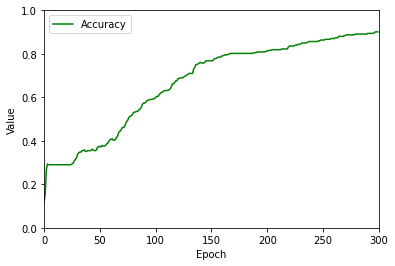

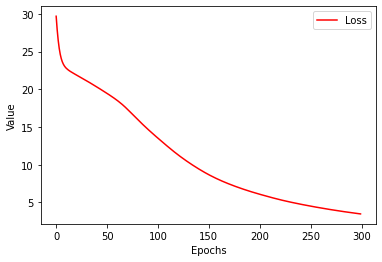

In [ ]:
# Visualisation de l'Accuracy et de la Loss

import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="green", label ="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
axes = plt.gca()
axes.set_xlim([0,n_epochs])
axes.set_ylim([0,1])
plt.show()

plt.plot(loss_list, c="red", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

## **6) Testing**

In [ ]:
# Exemple de test
test_tag = [["NOUN", "VERB", "DET", "NOUN", "NOUN"], ["DET", "NOUN", "VERB", "DET", "NOUN"]]
test_sentence = ["Everybody ate the dog apple".split(), "the dog ate the dog".split()]

# Pas de création de graphe dynamique et donc pas de calcul de gradient
with torch.no_grad():
  
  j = 0
  for sentence in test_sentence:
    print("\nSentence "+ str(j+1) +":", sentence)
    inputs = prepare_sequence(sentence, word_to_ix)
    tag_scores = model(inputs)
    #print("tag scores:\n", tag_scores)

    # Récupérer les tags prédits (indexés)
    _, predicted = torch.max(tag_scores, 1)
    #print("Predicted Tags indexed:", predicted)

    resultat = []
    for i in range(len(predicted)):
        for tag, index in tag_to_ix.items():
            if predicted[i] == index:
                resultat.append((sentence[i], tag))

    print("\t Actual Tags:\t", test_tag[j])
    print("\t Predict. Tags:\t", resultat)

    j += 1

    # Comparer avec les Tags réels
    #print("Actual Tags: \t", test_tag)


Sentence 1: ['Everybody', 'ate', 'the', 'dog', 'apple']
	 Actual Tags:	 ['NOUN', 'VERB', 'DET', 'NOUN', 'NOUN']
	 Predict. Tags:	 [('Everybody', 'NOUN'), ('ate', 'VERB'), ('the', 'DET'), ('dog', 'NOUN'), ('apple', 'NOUN')]

Sentence 2: ['the', 'dog', 'ate', 'the', 'dog']
	 Actual Tags:	 ['DET', 'NOUN', 'VERB', 'DET', 'NOUN']
	 Predict. Tags:	 [('the', 'DET'), ('dog', 'NOUN'), ('ate', 'VERB'), ('the', 'DET'), ('dog', 'NOUN')]


# **Partie 2**: **A Real Task** (Large Dataset)

1.   Split the dataset in 3 sets:  train / validation / test (80%,10%,10%)
2.   Learn the model and test it
3.   Tune the hyperparameters. What is the best score you can obtain ? 
4.   Start again with a bi-lstm

In [ ]:
# Accessing Files on Google Drive
from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## **Work Description**

Ceci est un résumé/survol de ce qui a été développé le long de cette seconde partie. J'ai, volontairement, laissé les résultats de chaque bout de code pour voir les résultats. Néanmoins, je vous invite à exécuter toutes les cellules (hors Annexes) pour vérifier par vous-même les résultats.

Mon choix s'est porté sur *Google Colab* comme environnement de développement dans le but d'utiliser la puissance de calcul sur GPU.

Le plan est le suivant:

1.   **Dependencies import**
  - Cela concerne toutes les librairies et modules nécessaires au développement de cette seconde partie.

2.   **Data Preparation methods**
  - La fonction *`clean_word()`:* permet de récupérer la racine d'un mot (*stemming*) puis de le convertir en minuscule
  - Classe *`BrownDataset`*: permet de créer un objet PyTorch *Dataset* contenant:
      + Le vocabulaire des mots (du mot vers son index et vice-versa): contenant à l'index 0 le `<PAD>` représentant le padding
      + Le vocabulaire des tags (du tag vers son index et vice-versa): contenant à l'index 0 le `<PAD>` représentant le padding
      + Le comptage des mots
      + le comptage des tags
      + Paramétré pour implémenter ou non le *Stemming* sur les mots des phrases
  - L'interrogation d'un élément du Dataset retournera un triplet:
      + Tensor de séquences
      + Tensor de tags des séquences correspondantes
      + Tensor de longueurs des séquences
  - La fonction *`collate_fn()`*: met en place le padding dans au sein des séquences et des tags
  - La fonction *`split_data()`*: éclate un jeu de données en plusieurs sous-ensembles pour les phrases d'entraînement, de validation et de test
  - La fonction *`get_dataloaders()`*: éclate le jeu de données en Train, Validation et Test où chacun est encapsulé dans un objet *DataLoader* qui sera itéré lors des phrases correspondantes
  - La fonction *`get_device()`*: définit la GPU comme périphérique de calcul si elle est disponible, sinon sur CPU

3.   **Neural Network**
  - Définition de la classe *`BrownTagger`* et permet de:
      +  définir les différentes couches du Réseau de Neurones par lesquelles les données transiteront lorsqu'elles seront injectées dans le modèle
      + ainsi qu'une méthode de calcul Coût (*Loss*)
      + Le modèle est basé sur des cellules ***LSTM*** ou ***Bi-LSTM***

4.   **Training, Evaluation, Running and Visualizing methods**
  - La fonction `train()`: permet d'entraîner le modèle sur les données de permet de  et d'optimiser les poids du Réseau de Neurones
  - La fonction `evaluate()`: permet d'évaluer le modèle sur les données de validation
  - La fonction `runner_visualizer()`: cette fonction est centrale car elle reçoit en arguments une liste d'hyperparamètres et permet, surtout, d'orchestrer l'entraînement et l'évaluation sur les données de validation sur un certain nombre d'époques et de contrôler les résultats de la fonction de coût (*`Loss`*) ainsi que la précision du modèle (*`Accuracy`*). Elle capture les métriques et les affiche visuellement sur des courbes

5.   **Run and Show results**
  - Cette partie est en quelque sorte la partie *`__main__`* ou l'exécution même de l'entraînement et de la validation avec des valeurs fixes des hyperparamètres après avoir éclaté les données en *`Train`*, *`Validation`* et *`Test`*, chacun encapsulé dans un *`DataLoader`* qui seront parcourus ultérieurement
  - Une seconde partie est réservée à l'évaluation du modèle sur le jeu de *`Test`* supposé non-optimisé en termes d'hyperparamètres 
  - **Remarque**: le modèle a tendance à *sur-apprendre* au bout de quelques époques.


6.   **Hyperparameters Optimization**
  - L'optimisation des hyperparamètres est une étape importante dans tout projet en Machine Learning car elle permet de trouver le meilleur compromis sur les valeurs des hyperparamètres de façon à optimiser les métriques du modèle sélectionné. Plusieurs méthodes et frameworks existent pour réaliser cela. Quelques recherches m'ont mené à 2 frameworks: *`RAY`* et *`HypOpt`*. Je les ai abandonné et rangés en Annexes de ce Notebook car je souhaitais maîtriser ce qu'il se passait dans cette étape de recherche.
  - Plusieurs méthodes existent, notamment: *`Baysian Optimization`*, *`Random Search`* et *`Grid Search`*
  - J'ai opté pour la méthode de *`Grid Search`*
  - La fonction *`grid_search()`*: permet de boucler sur les différentes combinaisons des hyperparamètres de notre choix et de capturer le meilleur modèle ayant la meilleure *`Validation Accuracy`* durant l'entraînement et la validation en évitant de prendre des *`Accuracy`* dans des moments d'*`Overfitting`*. Au final, cette fonction retourne un récapitulatif indiquant la meilleure combinaison d'hyperparamètres, la meilleure *`Validation Accuracy`* sans qu'il y ait *`Overfitting`*, l'historique des métriques capturées ainsi que le meilleur modèle.
  - Dans mon cas, j'ai choisi les valeurs des hyperparamètres qui suivent:
      + *LEARNING_RATE_LIST = [0.01, 0.001]*
      + *BATCH_SIZE_LIST = [256, 512]*
      + *BIDRECTIONAL_LIST = [False, True]*
      + *DROPOUT_LIST = [0.2, 0.3]*
      + *EMBEDDING_DIM_LIST = [100, 200]*
      + *HIDDEN_DIM_LIST = [200, 300]*
  - La meilleure *`Vlidation Accuracy`* obtenue: 97,26%
  - La meilleure combinaison résultante est la suivante: *{'num_epochs': 3, 'learning_rate': 0.01, 'embedding_dim': 100, 'hidden_dim': 300, 'num_layers': 2, 'batch_size': 512, 'bidirectional': True, 'dropout': 0.3}*


7.   **Inference on Test data**
  - Grâce à l'étape précédent, a priori, la meilleure combinaison d'hyperparamètres aura été révélée ainsi que le meilleur modèle. Ce dernier sera appliqué à ce niveau et sera évalué sur le jeu de Test.
  - L'inférence donne les résultats suivants:
      + *Loss* = 0.017
      + *Accuracy* = **98%**

## **1) Dependencies import**


In [ ]:
import pickle # for the real data
import torch  # Torch + shortcuts
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data
from torchtext import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

import time
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from nltk.stem import PorterStemmer

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## **2) Data Preparation methods**

In [ ]:
# Stemming + Lower

ps = PorterStemmer()

def clean_word(word):
  """Gets the root of a word and turn it into lower case

  Parameters
  ----------
  word : str
      A word in a sentence (in sequence of words)

  Returns
  -------
  str
      the root of the word in a lower case
  """
  
  p = re.compile(r'\d')
  m = p.match(word)
  if m:
    word = "9999"
  
  word_stem = ps.stem(word).lower()
  
  return word_stem

In [ ]:
from collections import Counter

class BrownDataset(Dataset):
    """
    A class used to instanciate a PyTorch Dataset object wrapping data

    ...

    Attributes
    ----------
    sents : list
        a list of sentences
    sent_lengths : list
        a list of actual lengths of the sentences
    tags : list
        a list of tags related to the words in the sentences
    stemming : boolean
        stemming application (True) or not (False)
    w2i : dict
        vocabulary of words indexed from the sentences (word to index)
    i2w : dict
        reverse vocabulary of words (index to word)
    t2i : dict
        tags of words indexed from the tags (tag to index)
    i2t : dict
        reverse vocabulary of tags (index to tag)
    word_count : dict
        dictionnary of words count
    tag_count : dict
        dictionnary of tags count
    """


    def __init__(self, mydata, stemming):
        """
        Parameters
        ----------
        mydata : list
            dataset of the original data
        stemming : boolean
            stemming application (True) or not (False)
        """

        self.sents = []
        self.sent_lengths = []
        self.tags = []
        self.stemming = stemming

        # Extraire les Phrases et les Tags
        for tagged_sent in mydata:
            words, tags = tagged_sent

            self.sents.append(words)
            self.sent_lengths.append(len(words))
            self.tags.append(tags)

        # Encapsuler les mots (en minuscule) dans un objet Counter
        if self.stemming:
          c = Counter([clean_word(word) for sent in self.sents for word in sent])
        else:
          c = Counter([word for sent in self.sents for word in sent])

        # Construire le vocabulaire des mots
        self.w2i = {"<PAD>": 0, "<UNK>": 1}
        for i, (w, _) in enumerate(c.most_common(len(c) - 2), 2):
            self.w2i[w] = i

        # Construire le dictionnaire inverse du vocabulaire des mots
        self.i2w = {i: w for w, i in self.w2i.items()}

        # Construire le dictionnaire des tags
        self.t2i = {"<PAD>": 0}
        for i, t in enumerate({tag for tags in self.tags for tag in tags}, 1):
            self.t2i[t] = i

        # Construire le dictionnaire inverse du vocabulaire des tags
        self.i2t = {i: t for t, i in self.t2i.items()}


        # Word count
        word_count = {}

        for sent in self.sents:
          for word in sent:
            if word not in word_count:
              word_count[word] = 1
            else:
              word_count[word] += 1

        # Tag count
        tag_count = {}

        for tags in self.tags:
          for tag in tags:
            if tag in tag_count:
              tag_count[tag] += 1
            else:
              tag_count[tag] = 1
        

        # Word count and Tag count dictionnaries sorting descending
        self.word_count = {key: value for key, value in sorted(word_count.items(), key=lambda x: x[1], reverse=True)}
        self.tag_count = {key: value for key, value in sorted(tag_count.items(), key=lambda x: x[1], reverse=True)}

    
    def __getitem__(self, index):
        
        """
        Parameters
        ----------
        index : int
            index of the items to return
        """

        # When stemming applied
        if self.stemming:
          
          return torch.tensor([self.w2i.get(clean_word(w), self.w2i["<UNK>"]) for w in self.sents[index]]), \
                torch.tensor([self.t2i[t] for t in self.tags[index]]), \
                torch.tensor([self.sent_lengths[index]])
        
        # without stemming
        else:
          return torch.tensor([self.w2i.get(w, self.w2i["<UNK>"]) for w in self.sents[index]]), \
                torch.tensor([self.t2i[t] for t in self.tags[index]]), \
                torch.tensor([self.sent_lengths[index]])


    def __len__(self):
        return len(self.sents)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    """Gets the padded sequence(s) and corresponding tags according to the batch content

    Parameters
    ----------
    batch : Tensor
        An indexed sequence of words and their tags

    Returns
    -------
    Tensor 1
        sentence(s) padded
    Tensor 2
        tags padded
    Tensor 3
        actual lengths of the sentences (without the padding)
    """


    #sents, tags = list(zip(*batch))
    #return pad_sequence(sents, batch_first=True), pad_sequence(tags, batch_first=True)

    sents, tags, sents_lengths = list(zip(*batch))
    return pad_sequence(sents, batch_first=True), pad_sequence(tags, batch_first=True), pad_sequence(sents_lengths, batch_first=True)

In [ ]:
# Fonction pour éclater le jeu de données en 3 sous-ensembles: Training, Validation et Test
def split_data(data, train_ratio, validation_ratio, test_ratio):

  """Splits the whole dataset into three parts: Training, Validation and Testing sets

  Parameters
  ----------
  data : list
      whole dataset to split
  train_ratio : float
      training set ratio from the whole dataset
  validation_ratio : float
      validation set ratio from the whole dataset
  test_ratio : float
      testing set ratio from the whole dataset

  Returns
  -------
  list
      training set
  list
      validation set
  list
      testing set
  """

  dataset_length = len(data)

  train_data, valid_data, test_data = \
    torch.utils.data.random_split(data, 
      [int(train_ratio * dataset_length), int(validation_ratio * dataset_length), int(test_ratio * dataset_length)])
  
  return train_data, valid_data, test_data

In [ ]:
def get_dataloaders(mydata_file_path, stemming, batch_size, train_ratio, validation_ratio, test_ratio):

  """Gets Datasets and DataLoaders from the differents datasets (All, Training, Validation and Testing)

  Parameters
  ----------
  mydata_file_path : str
      data file path
  stemming : boolean
      stemming application (True) or not (False)
  batch_size : int
      size of the batch that will be processed at once for Training, Validation and Testing
  train_ratio : float
      training set ratio from the whole dataset
  validation_ratio : float
      validation set ratio from the whole dataset
  test_ratio : float
      testing set ratio from the whole dataset

  Returns
  -------
  Dataset
      full data from the whole dataset
  (Dataset, DataLoader): tuple
      training Dataset and DataLoader
  (Dataset, DataLoader): tuple
      Validation Dataset and DataLoader
  (Dataset, DataLoader): tuple
      Testing Dataset and DataLoader
  """
  
  #mydata = pickle.load( open( "/content/gdrive/My Drive/Colab Notebooks/NLP/data/brown.postag.dataset.p", "rb" ) )
  mydata = pickle.load( open( mydata_file_path , "rb" ) )

  # Build the Dataset on the whole data
  mydata_dataset = BrownDataset(mydata, stemming)


  # ===[DATA SPLIT]===
  train_dataset, valid_dataset, test_dataset = split_data(mydata_dataset, train_ratio, validation_ratio, test_ratio)


  # ===[DATA LOADERS]===
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


  # Sets
  sets = {
    'all_set': {'ratio': 1.0, 'nb_examples': len(mydata_dataset)},
    'train_set': {'ratio': train_ratio, 'nb_examples': len(train_dataset)},
    'validation_set': {'ratio': validation_ratio, 'nb_examples': len(valid_dataset)},
    'test_set': {'ratio': test_ratio, 'nb_examples': len(test_dataset)}
  }

  print("Sets: ", sets)


  return mydata_dataset, (train_dataset, train_dataloader), (valid_dataset, valid_dataloader), (test_dataset, test_dataloader)

In [ ]:
def get_device():

  """Gets the device (CPU or GPU) on which the treatments will be performed

  Parameters
  ----------
  None

  Returns
  -------
  str
     the target device
  """

  # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
  is_cuda = torch.cuda.is_available()

  # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
  if is_cuda:
      device = torch.device("cuda:0")
      print("Device: GPU is available")
  else:
      device = torch.device("cpu")
      print("Device: GPU not available, CPU used")

  return device

## **3) Neural Network**

In [ ]:
class BrownTagger(nn.Module):

    """
    A class used create and manage Neural Network architecture and execution on data. Also, computing the loss.

    ...

    Attributes
    ----------
    hidden_dim : int
        size of the hidden layer
    batch_size : int
        batch size
    num_layers : int
        number of layers
    tagset_size : int
        number of output classes corresponding to the number of tags
    bidirectional : int
        indicates whether the LSTM is on one direction (False) or bidrectional (True)
    padding_idx: int
        index of the padding tag <PAD>
    word_embeddings: int
        result of the Embedding layer
    lstm: int
        result of the LSTM cells
    dropout: float
        dropout ratio regularization application
    read_out: int
        final result of the neural network
    debug_mode : boolean
        debug mode used to display (True) intermediate results during the execution


    Methods
    -------
    init_hidden():
        hidden layer initialization
    forward(sentence, sentence_lengths):
        neural network orchestration when it receives data
    loss(predictions, targets):
        loss calculation
    """

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, num_layers, batch_size, bidirectional, dropout, debug_mode):

        super(BrownTagger, self).__init__()

        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.debug_mode = debug_mode
        #self.tagset_size = tagset_size - 1
        self.tagset_size = tagset_size
        self.bidirectional = bidirectional
        
        # 1) Couche Embedding
        # <PAD> Index
        self.padding_idx = 0 #vocab_size['<PAD>'], servira à mettre à zéro les vecteurs d'embedding du padding <PAD>
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=self.padding_idx)

        # 2) Couche LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional = bidirectional, batch_first=True, dropout = dropout if num_layers > 1 else 0) # avec Dropout
        #self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional = bidirectional, batch_first=True) # sans Dropout


        # 3) Couche de Sortie (Linéaire/FC): re-projecter vers l'espace des Tags (classification)
        self.read_out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, tagset_size)

        # Un peu de régularisation avec du Dropout
        self.dropout = nn.Dropout(dropout)

        if self.debug_mode:
          print("\t####[ INIT TAGGER ]####")
          print("\t\t embedding_dim:", embedding_dim)
          print("\t\t hidden_dim:", hidden_dim)
          print("\t\t vocab_size:", vocab_size)
          print("\t\t tagset_size:", tagset_size)

          print("\t\t self.word_embeddings:", self.word_embeddings)
          print("\t\t self.lstm:", self.lstm)
          print("\t\t self.read_out:", self.read_out)
          print("\t#####################")


    def init_hidden(self):

        #hidden_a = torch.zeros(8, self.batch_size, self.hidden_dim) # Hidden State (nb layers, batch size, hidden dim)
        #hidden_b = torch.zeros(8, self.batch_size, self.hidden_dim) # Cell State (nb layers, batch size, hidden dim)

        hidden_a = torch.randn(self.num_layers * 2 if self.bidirectional else self.num_layers, self.batch_size, self.hidden_dim).to(DEVICE) # Hidden State (nb layers, batch size, hidden dim)
        hidden_b = torch.randn(self.num_layers * 2 if self.bidirectional else self.num_layers, self.batch_size, self.hidden_dim).to(DEVICE) # Cell State (nb layers, batch size, hidden dim)

        #hidden = (torch.zeros(2, batch_size, self.hidden_dim), # Hidden State (nb layers, batch size, hidden dim)
        #        torch.zeros(2, batch_size, self.hidden_dim) ) # Cell State (nb layers, batch size, hidden dim)

        #return (torch.zeros(1, batch_size, self.hidden_dim),
        #        torch.zeros(1, batch_size, self.hidden_dim))

        return (hidden_a, hidden_b)



    def forward(self, sentence, sentence_lengths):
        if self.debug_mode:
          print("\t####[ FORWARD ]####")
          print("\t\t sentence shape:", sentence.shape)
          print("\t\t sentence_lengths:", sentence_lengths)

        # Ré-initialisation le Hidden State de la LSTM
        # /!\: A faire avant d'exécuter sur un nouveau batch, sinon, la LSTM traitera le nouveau batch comme une suite de séquence
        
        self.hidden = self.init_hidden()


        #batch_size, seq_len, _ = sentence.size()
        batch_size, seq_len = sentence.size()


        # =============================================================
        # 1) Intégration (Embedding) de l'input
        #   Transformation de Dimension: (batch_size, seq_len, 1) -> (batch_size, seq_len, embedding_dim)

        #word_embeded = self.word_embeddings(sentence) # sans Dropout
        word_embeded = self.dropout(self.word_embeddings(sentence)) # avec Dropout


      

        if self.debug_mode:
          print("\t\t word_embeded shape:", word_embeded.shape)
          print("\t\t self.hidden content shape:")
          print("\t\t\t self.hidden[0] Hidden State:", self.hidden[0].shape)
          print("\t\t\t self.hidden[1] Cell State:", self.hidden[1].shape)


        # =============================================================
        #2) Exécution à travers le RNN (LSTM)
        #   Transformation de Dimension: (batch_size, seq_len, embedding_dim) -> (batch_size, seq_len, nb_lstm_units)


        if self.debug_mode:
          print("\t\t sentence_lengths shape:", sentence_lengths.shape)
          print("\t\t sentence_lengths:", sentence_lengths)
          print("\t\t sentence_lengths.squeeze():", sentence_lengths.squeeze())
          print("\t\t sentence_lengths.squeeze().shape:", sentence_lengths.squeeze().shape)

          # a) Pack padding: cacher les éléments '<PAD>' à la LSTM
        #X = torch.nn.utils.rnn.pack_padded_sequence(word_embeded, sentence_lengths.squeeze(), batch_first=True)
        X = torch.nn.utils.rnn.pack_padded_sequence(word_embeded, sentence_lengths.squeeze(), enforce_sorted=False, batch_first=True)

          # b) Passage à travers la LSTM
        X, self.hidden = self.lstm(X, self.hidden)

          # c) Pad pack: remettre les éléments '<PAD>' à la LSTM
        lstm_out, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)

        if self.debug_mode:
          print("\t\t lstm_out shape:", lstm_out.shape)

        # =============================================================
        # 3) Projection sur l'espace des Tags (nb de classes finales)
        #   Transformation de Dimension: (batch_size, seq_len, nb_lstm_units) -> (batch_size * seq_len, nb_lstm_units)


        tag_outputs = lstm_out.contiguous()
        tag_outputs = tag_outputs.view(-1, tag_outputs.shape[2]) # X.shape[2]: est le nb de lstm (hidden dim)

        # Exécuter à travers la couche Linéaire
        #tag_outputs = self.read_out(tag_outputs) # sans Dropout
        tag_outputs = self.read_out(self.dropout(tag_outputs)) # avec Dropout


        if self.debug_mode:
          print("\t\t tag_outputs shape:", tag_outputs.shape)


        # =============================================================
        # 4) Activation Softmax
        #    Transformation de Dimension: (batch_size * seq_len, nb_lstm_units) -> (batch_size, seq_len, nb_tags)
        Z = F.log_softmax(tag_outputs, dim=1)

        # Il est meilleur pour le cerveau de revenir à la forme: (batch_size, seq_len, nb_tags)
        tag_scores = Z.view(batch_size, seq_len, self.tagset_size)

        if self.debug_mode:
          print("\t\t tag_scores shape:", tag_scores.shape)
          print("\t#####################")

        return tag_scores
    

    
    def loss(self, predictions, targets):

      # A plat tous les Labels
      targets = targets.view(-1)

      # A plat toutes les prédictions
      predictions = predictions.view(-1, self.tagset_size)


      if self.debug_mode:
        print("\t####[ LOSS ]####")
        print("\t\t RESHAPE predictions shape:", predictions.shape)
        print("\t\t RESHAPE targets shape:", targets.shape)
        print("\t\t RESHAPE targets:", targets)


      # Créer un masque en filtrant tous les Tokens qui ne sont pas un token de Padding
      #tag_pad_token = self.tags['<PAD>']
      mask = (targets > self.padding_idx).float()

      if self.debug_mode:
        print("\t\t mask:", mask)

      # Compter le nombre de tokens

      if self.debug_mode:
        print("\t\t torch.sum(mask):", torch.sum(mask))
        print("\t\t torch.sum(mask).item():", torch.sum(mask).item())


      #nb_tokens = int(torch.sum(mask).data[0])
      nb_tokens = int(torch.sum(mask).item())


      if self.debug_mode:
        print("\t\t predictions shape:", predictions.shape)
        print("\t\t predictions .shape[0]:", predictions.shape[0])


      # Choisir les valeurs des labels et RAZ le reste du masque
      predictions = predictions[range(predictions.shape[0]), targets] * mask

      # Calculer la Cross Entropy Loss qui ignore tous les tokens <PAD>
      ce_loss = -torch.sum(predictions)/nb_tokens


      if self.debug_mode:
        print("\t#####################")

      return ce_loss

## **4) Training, Evaluation, Running and Visualizing methods**

### a) Training method

In [ ]:
# Fonction de Training du modèle sur le Training set
def train(model, dataloader, optimizer):

  """Computes and Gets the Training Loss and Accuracy during one epoch

  Parameters
  ----------
  model : BrownTagger
      the neural network object, its attributes and methods
  dataloader : DataLoader
      training DataLoader
  optimizer : optim
      Optimizer (SGD, Adam, ...)

  Returns
  -------
  float
      Training epoch Loss
  float
      Training epoch Accuracy
  """

  train_epoch_loss = 0.0
  train_epoch_accuracy = 0.0
  correct = 0
  total_correct = 0
  Total_item = 0
  total_words = 0

  model.train()
  for i, (inputs, targets, inputs_lengths) in enumerate(dataloader):

    inputs = inputs.to(DEVICE)
    targets = targets.to(DEVICE)
   
    model.zero_grad()

    tag_scores = model(inputs, inputs_lengths)

    loss_train = model.loss(tag_scores, targets)

    train_epoch_loss += loss_train.item() * inputs.shape[1]

    loss_train.backward()
    optimizer.step()

    _, predicted_tags = torch.max(tag_scores.permute(0, 2, 1), 1)
    
    Total_item += targets.size(0)

    total_words += inputs_lengths.sum().item()


    # Calcul de l'accuracy en fonction du nb de Tags corrects prédits en excluant les PAD
    for sentence_index in range(predicted_tags.shape[0]):
      correct = (predicted_tags[sentence_index, :inputs_lengths[sentence_index].item()] ==  targets[sentence_index, :inputs_lengths[sentence_index].item()]).sum().item()
      total_correct += correct

      if DEBUG_MODE:
        print("\t correct phrase["+str(sentence_index)+"]:", correct)



    
    if DEBUG_MODE:
      print("\t inputs shape:", inputs.shape)
      print("\t inputs: \n\t", inputs)
      print("\t targets shape:", targets.shape)
      print("\t inputs_lengths:", inputs_lengths)
      print("\t tag_scores shape [batch_size, seq_len, nb_tags]:", tag_scores.shape)
      print("\t targets shape:", targets.shape)
      print("\t loss_train:", loss_train)
      print("\t predicted_tags shape:", predicted_tags.shape)
      print("\t targets.shape:", targets.shape)
      print("\t predicted_tags:", predicted_tags)
      print("\t targets:", targets)
      print("\t inputs_lengths:", inputs_lengths)
      print("\t total_correct:", total_correct)

    #train_epoch_accuracy = total_correct

    if DEBUG_MODE:
      break


  train_epoch_loss = train_epoch_loss/Total_item
  train_epoch_accuracy = total_correct/total_words
  

  if DEBUG_MODE:
    print("Total_item:", Total_item)
    print("train_epoch_loss = train_epoch_loss/Total_item:", train_epoch_loss)
    print("total_words:", total_words)
    print("total_correct:", total_correct)
    print("train_epoch_accuracy = total_correct/total_words:", train_epoch_accuracy)




  return train_epoch_loss, train_epoch_accuracy

### b) Evaluation method

In [ ]:
# Fonction d'évaluation du modèle sur le Validation set
def evaluate(model, dataloader):

  """Evaluates the model on the Validation data during one epoch

  Parameters
  ----------
  model : BrownTagger
      the neural network object, its attributes and methods
  dataloader : DataLoader
      validation DataLoader

  Returns
  -------
  float
      Validation epoch Loss
  float
      Validation epoch Accuracy
  """

  valid_epoch_loss = 0.0
  valid_epoch_accuracy = 0.0
  correct_val = 0
  total_correct_val = 0
  Total_item = 0
  total_words = 0


  # Zone d'évaluation
  model.eval()

  with torch.no_grad():
    
    for i, (inputs, targets, inputs_lengths) in enumerate(dataloader):

      inputs = inputs.to(DEVICE)
      targets = targets.to(DEVICE)

      tag_scores = model(inputs, inputs_lengths)

      loss_valid = model.loss(tag_scores, targets)

      valid_epoch_loss += loss_valid.item() * inputs.shape[1]

      _, predicted_tags = torch.max(tag_scores.permute(0, 2, 1), 1)

      Total_item += targets.size(0)

      total_words += inputs_lengths.sum().item()

      # Calcul de l'accuracy en fonction du nb de Tags corrects prédits en excluant les PAD
      for sentence_index in range(predicted_tags.shape[0]):
        correct_val = (predicted_tags[sentence_index, :inputs_lengths[sentence_index].item()] ==  targets[sentence_index, :inputs_lengths[sentence_index].item()]).sum().item()
        total_correct_val += correct_val

        if DEBUG_MODE:
          print("\t correct phrase["+str(sentence_index)+"]:", correct_val)




      if DEBUG_MODE:
        print("\t tag_scores shape [batch_size, seq_len, nb_tags]:", tag_scores.shape)
        print("\t targets shape:", targets.shape)
        print("\t RESHAPE tag_scores:", tag_scores.shape)
        print("\t RESHAPE targets:", targets.shape)
        print("\t total_correct_val:", total_correct_val)

      if DEBUG_MODE:
        break


      #valid_epoch_accuracy += total_correct_val

  valid_epoch_loss = valid_epoch_loss/Total_item
  valid_epoch_accuracy = total_correct_val/total_words

  if DEBUG_MODE:
    print("Total_item:", Total_item)
    print("valid_epoch_loss = valid_epoch_loss/Total_item:", valid_epoch_loss)
    print("total_words:", total_words)
    print("total_correct_val:", total_correct_val)
    print("valid_epoch_accuracy = total_correct_val/total_words:", valid_epoch_accuracy)



  return valid_epoch_loss, valid_epoch_accuracy

### c) Run and Visualize method

In [ ]:
def runner_visualizer(num_epochs, train_dataloader, learning_rate, valid_dataloader, embedding_dim, hidden_dim, vocab_size, tagset_size, num_layers, batch_size, bidirectional, dropout, display_graphs, debug_mode):

  """Trains the model on Training data and evaluates it on Validation data through the hyperparameters got from arguments and displays the results graphically

  Parameters
  ----------
  num_epochs : int
      number of epochs
  train_dataloader : DataLoader
      Training set DataLoader
  learning_rate : float
      learning speed (step in the Gradient Descent)
  valid_dataloader : DataLoader
      Validation set DataLoader
  embedding_dim : int
      dimensions of the embedding (projection space)
  hidden_dim : int
      size of the hidden layer
  vocab_size : int
      number of words in the vocabulary
  tagset_size : int
      number of output classes corresponding to the number of tags
  num_layers : int
      number of layers
  batch_size : int
      batch size
  bidirectional : boolean
      indicates whether the LSTM is on one direction (False) or bidrectional (True)
  dropout : float
      dropout ratio regularization application
  display_graphs : boolean
      allows to display (True) graphically the final results of the training and evaluation
  debug_mode : boolean
      debug mode used to display (True) intermediate results during the execution

  Returns
  -------
  BrownTagger
      the model trained
  dict
      hyperparameters dictionary (names and values)
  list
      metrics history (Training and Validation Losses, Training and Validation Accuracies)
  """

  # Hyperparameters
  hyperparameters = {
    'num_epochs':num_epochs,
    'learning_rate':learning_rate,
    'embedding_dim':embedding_dim,
    'hidden_dim':hidden_dim,
    'num_layers':num_layers,
    'batch_size':batch_size,
    'bidirectional':bidirectional,
    'dropout':dropout
  }

  print("hyperparameters: ", hyperparameters)


  # ===[MODEL, LOSS, OPTIMIZER]===
  model = BrownTagger(embedding_dim=embedding_dim, hidden_dim=hidden_dim, vocab_size=vocab_size, tagset_size=tagset_size
            , num_layers=num_layers
            , batch_size=batch_size
            , bidirectional=bidirectional
            , dropout=dropout
            , debug_mode=debug_mode
          ).to(DEVICE)

  #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
 

  # ===[TRAINING]===
  train_loss_list = []
  train_acc_list = []

  valid_loss_list = []  
  valid_acc_list = []

  best_valid_loss = float('inf')
  best_valid_acc_wo_overfitting = 0
  best_model = None

  print_every = 1



  print("Start TRAINING ...")
  for epoch in range(num_epochs):
    
    epoch_start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer)
    valid_loss, valid_acc = evaluate(model, valid_dataloader)

    train_loss_list.append(float( train_loss ))
    train_acc_list.append(float( train_acc ))
    valid_loss_list.append(float( valid_loss ))
    valid_acc_list.append(float( valid_acc ))


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

        # No Overfitting then save the model
        if train_acc <= valid_acc:
          torch.save(model.state_dict(), 'best-model.pt')
          best_model = model

          best_valid_acc_wo_overfitting = valid_acc

          if (epoch + 1) % print_every == 0 :
            print("\t Epoch "+ str(epoch+1) +"/"+ str(num_epochs), "- duration: "+ str(int(time.time() - epoch_start_time)) +"s :\t Loss: "+ str(train_loss), "\t | Train Acc: "+ str(train_acc), "\t ||  Val Loss: "+ str(valid_loss), " \t|\t Val Acc: "+ str(valid_acc), "\t>>> SAVED")

        # Overfitting
        else:
          if (epoch + 1) % print_every == 0 :
            print("\t Epoch "+ str(epoch+1) +"/"+ str(num_epochs), "- duration: "+ str(int(time.time() - epoch_start_time))  +"s :\t Loss: "+ str(train_loss), "\t | Train Acc: "+ str(train_acc), "\t ||  Val Loss: "+ str(valid_loss), " \t|\t Val Acc: "+ str(valid_acc), "\t>>> *Overfitting" if train_acc > valid_acc else "")

    else:
      if (epoch + 1) % print_every == 0 :
        print("\t Epoch "+ str(epoch+1) +"/"+ str(num_epochs), "- duration: "+ str(int(time.time() - epoch_start_time))  +"s :\t Loss: "+ str(train_loss), "\t | Train Acc: "+ str(train_acc), "\t ||  Val Loss: "+ str(valid_loss), " \t|\t Val Acc: "+ str(valid_acc), "\t>>> *Overfitting" if train_acc > valid_acc else "")



  metrics_history = {
      'train_loss':train_loss_list,
      'train_acc':train_acc_list,
      'valid_loss':valid_loss_list,
      'valid_acc':valid_acc_list,
      'best_valid_acc_wo_overfitting':best_valid_acc_wo_overfitting
  }



  # ===[VISUALIZATION]===
  # Visualisation de l'Accuracy et de la Loss du Training et de la Validation
  if display_graphs:

    plt.plot(train_acc_list, c="blue", label="Train Acc")
    plt.plot(valid_acc_list, c="orange", label="Validation Acc")

    plt.title("Accuracy (Training & Validation)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    axes = plt.gca()
    axes.set_xlim([0,num_epochs])
    axes.set_ylim([0,1])

    plt.show()


    plt.plot(train_loss_list, c="blue", label ="Train Loss")
    plt.plot(valid_loss_list, c="orange", label="Validation Loss")

    plt.title("Loss (Training & Validation)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    axes = plt.gca()
    axes.set_xlim([0,num_epochs])
    plt.show()


  return best_model, hyperparameters, metrics_history

## **5) Run and Show results**

In [ ]:
mydata_file_path = "/content/gdrive/My Drive/Colab Notebooks/NLP/data/brown.postag.dataset.p"

# ===[HYPER PARAMETERS]===
NUM_EPOCHS = 10
LEARNING_RATE = 0.1
EMBEDDING_DIM = 10
HIDDEN_DIM = 10
NUM_LAYERS = 2
BATCH_SIZE = 64
BIDRECTIONAL = True
DROPOUT = 0.1
STEMMING = False
DISPLAY_GRAPHS = True
DEVICE = get_device()

# ===[PARAMETERS]===
DEBUG_MODE = False

# Best combination: 
# hyperparameters:  {'num_epochs': 3, 'learning_rate': 0.01, 'embedding_dim': 100, 'hidden_dim': 200, 'num_layers': 2, 'batch_size': 256, 'bidirectional': True, 'dropout': 0.3}
# hyperparameters:  {'num_epochs': 3, 'learning_rate': 0.01, 'embedding_dim': 100, 'hidden_dim': 200, 'num_layers': 2, 'batch_size': 512, 'bidirectional': True, 'dropout': 0.3} => Valid Acc w/o overfitting: 0.9726059289151017



# Get datasets and dataloaders
mydata_dataset, (train_dataset, train_dataloader), (valid_dataset, valid_dataloader), (test_dataset, test_dataloader) = get_dataloaders(mydata_file_path, STEMMING, batch_size=BATCH_SIZE, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1)

Device: GPU is available
Sets:  {'all_set': {'ratio': 1.0, 'nb_examples': 57340}, 'train_set': {'ratio': 0.8, 'nb_examples': 45872}, 'validation_set': {'ratio': 0.1, 'nb_examples': 5734}, 'test_set': {'ratio': 0.1, 'nb_examples': 5734}}


hyperparameters:  {'num_epochs': 10, 'learning_rate': 0.1, 'embedding_dim': 10, 'hidden_dim': 10, 'num_layers': 2, 'batch_size': 64, 'bidirectional': True, 'dropout': 0.1}
Start TRAINING ...
	 Epoch 1/10 - duration: 25s :	 Loss: 0.3899196132830431 	 | Train Acc: 0.8772063466067892 	 ||  Val Loss: 0.19641540819317113  	|	 Val Acc: 0.9390287986504399 	>>> SAVED
	 Epoch 2/10 - duration: 24s :	 Loss: 0.21460207153818553 	 | Train Acc: 0.9363873990160734 	 ||  Val Loss: 0.1735737797692756  	|	 Val Acc: 0.9503038231800733 	>>> SAVED
	 Epoch 3/10 - duration: 24s :	 Loss: 0.19601254888693598 	 | Train Acc: 0.9435104157014518 	 ||  Val Loss: 0.16883320533412235  	|	 Val Acc: 0.9514743600778063 	>>> SAVED
	 Epoch 4/10 - duration: 24s :	 Loss: 0.18496593674966422 	 | Train Acc: 0.9469086904897869 	 ||  Val Loss: 0.16355910948450073  	|	 Val Acc: 0.952352262751106 	>>> SAVED
	 Epoch 5/10 - duration: 24s :	 Loss: 0.18365630167554303 	 | Train Acc: 0.9478234448636919 	 ||  Val Loss: 0.15973072853374

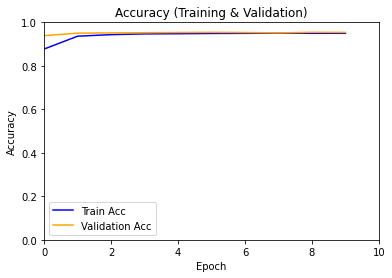

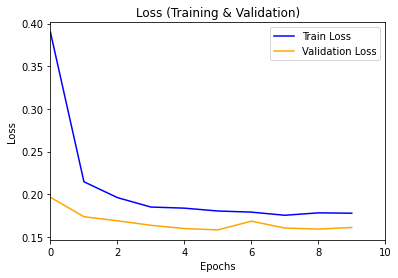

In [ ]:
# Run and show results
best_model, hyperparameters, metrics_history = runner_visualizer(
    num_epochs=NUM_EPOCHS, 
    train_dataloader=train_dataloader, 
    learning_rate=LEARNING_RATE, 
    valid_dataloader=valid_dataloader, 
    embedding_dim=EMBEDDING_DIM, 
    hidden_dim=HIDDEN_DIM, 
    vocab_size=len(mydata_dataset.w2i),  # Words Vocabulary size
    tagset_size=len(mydata_dataset.t2i), # Tags Vocabulary size
    num_layers=NUM_LAYERS, 
    batch_size=BATCH_SIZE, 
    bidirectional=BIDRECTIONAL, 
    dropout=DROPOUT,
    display_graphs=DISPLAY_GRAPHS,
    debug_mode=DEBUG_MODE)

### **Inference** on Test data after Training step

In [ ]:
# Prédiction de Tags sur des phrases "normalement" jamais vues

#model.load_state_dict(torch.load('best-model.pt'))

test_loss, test_acc = evaluate(best_model, test_dataloader)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}')

Test Loss: 0.161 | Test Acc: 0.95


## **6) Hyperparameters Optimization**

### **a) by Grid Search**

### a.1) Grid Search method

In [ ]:
def grid_search(mydata_file_path, num_epochs, learning_rate_list, batch_size_list, bidrectional_list, dropout_list, embedding_dim_list, hidden_dim_list):

  """Computes multiples combinations of hyperparameters and gets the best results

  Parameters
  ----------
  mydata_file_path : str
      data file path
  num_epochs : int
      number of epochs
  learning_rate_list : list
      learning rates list
  batch_size_list : list
      batch sizes list
  bidrectional_list : list
      LSTM (False) or Bi-LSTM (True) boolean list
  dropout_list : list
      dropout regularization ratios list
  embedding_dim_list : list
      embedding dimensions list
  hidden_dim_list : list
      hidden sizes list

  Returns
  -------
  BrownTagger
      the model trained and evaluated
  dict
      best hyperparameters combination
  list
      metrics history of the best combination
  int
      Best trial number 
  """

  # ===[HYPER PARAMETERS]===
  #NUM_EPOCHS = 3
  #LEARNING_RATE = 0.001
  #EMBEDDING_DIM = 100
  #HIDDEN_DIM = 100
  NUM_LAYERS = 2
  #BATCH_SIZE = 128
  #BIDRECTIONAL = True
  #DROPOUT = 0.2
  STEMMING = False
  DISPLAY_GRAPHS = False


  # ===[PARAMETERS]===
  DEBUG_MODE = False


  # Get datasets and dataloaders
  #mydata_dataset, (train_dataset, train_dataloader), (valid_dataset, valid_dataloader), (test_dataset, test_dataloader) = get_dataloaders(mydata_file_path, STEMMING, batch_size=BATCH_SIZE, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1)


  max_acc = 0

  trial = 1
  best_trial = 0
  num_trials = len(learning_rate_list) * len(batch_size_list) * len(bidrectional_list) * len(dropout_list) * len(embedding_dim_list) * len(hidden_dim_list)


  print("\nStart Grid Search ...\n")

  for lr in learning_rate_list:
    for bs in batch_size_list:
      for bi in bidrectional_list:
        for dp in dropout_list:
          for embed_dim in embedding_dim_list:
            for hidden in hidden_dim_list:
              
              print("TRIAL "+ str(trial) +"/"+ str(num_trials), ":")
              
              # Run and show results
              model, hyperparameters, metrics_history = runner_visualizer(
                  num_epochs=num_epochs, 
                  train_dataloader=train_dataloader, 
                  learning_rate=lr, 
                  valid_dataloader=valid_dataloader, 
                  embedding_dim=embed_dim, 
                  hidden_dim=hidden, 
                  vocab_size=len(mydata_dataset.w2i),  # Words Vocabulary size
                  tagset_size=len(mydata_dataset.t2i), # Tags Vocabulary size
                  num_layers=NUM_LAYERS, 
                  batch_size=bs, 
                  bidirectional=bi, 
                  dropout=dp,
                  display_graphs=DISPLAY_GRAPHS,
                  debug_mode=DEBUG_MODE)
              

              

              train_loss_list = metrics_history['train_loss']
              train_acc_list = metrics_history['train_acc']
              valid_loss_list = metrics_history['valid_loss']
              valid_acc_list = metrics_history['valid_acc']
              best_valid_acc_wo_overfitting = metrics_history['best_valid_acc_wo_overfitting']
              

              #print("valid_acc_list:", valid_acc_list)


              # Check accuracy and save model
              #avg_acc = sum(valid_acc_list)/len(valid_acc_list)

              if (max_acc < best_valid_acc_wo_overfitting):
                best_trial = trial
                max_acc = best_valid_acc_wo_overfitting
                best_model = model
                best_hyperparameters = hyperparameters
                metrics = metrics_history

                torch.save(model, 'best_model.pt')




              trial += 1

              print("==========================================================")




  # best model characteristics
  print("\n\n===[ SUMMARY ]===")
  print("Best TRIAL:", best_trial)
  print("\t Best Model Hyperparameters:", best_hyperparameters)
  print("\t Best Model Validation Accuracy with no Overfitting:", max_acc)
  print("\t Best Model Historical Metrics:", metrics)

  return best_model, best_hyperparameters, metrics, best_trial

### a.2) Run Grid Search

In [ ]:
LEARNING_RATE_LIST = [0.01, 0.001]
BATCH_SIZE_LIST = [256, 512]
BIDRECTIONAL_LIST = [False, True]
DROPOUT_LIST = [0.2, 0.3]
EMBEDDING_DIM_LIST = [100, 200]
HIDDEN_DIM_LIST = [200, 300]

NUM_EPOCHS_GS = 3

best_model_GS, best_hyperparameters_GS, metrics, best_trial = grid_search(
      mydata_file_path, 
      num_epochs=NUM_EPOCHS_GS, 
      learning_rate_list=LEARNING_RATE_LIST, 
      batch_size_list=BATCH_SIZE_LIST, 
      bidrectional_list=BIDRECTIONAL_LIST, 
      dropout_list=DROPOUT_LIST, 
      embedding_dim_list=EMBEDDING_DIM_LIST, 
      hidden_dim_list=HIDDEN_DIM_LIST)


#best_model = best_model_GS


Start Grid Search ...

TRIAL 1/64 :
hyperparameters:  {'num_epochs': 3, 'learning_rate': 0.01, 'embedding_dim': 100, 'hidden_dim': 200, 'num_layers': 2, 'batch_size': 256, 'bidirectional': False, 'dropout': 0.2}
Start TRAINING ...
	 Epoch 1/3 - duration: 13s :	 Loss: 0.171718706122824 	 | Train Acc: 0.8241387409790566 	 ||  Val Loss: 0.06539015918918133  	|	 Val Acc: 0.934243368392061 	>>> SAVED
	 Epoch 2/3 - duration: 12s :	 Loss: 0.05665500123602123 	 | Train Acc: 0.94037827086642 	 ||  Val Loss: 0.0469417373789783  	|	 Val Acc: 0.9503296438469351 	>>> SAVED
	 Epoch 3/3 - duration: 12s :	 Loss: 0.040492726204202835 	 | Train Acc: 0.956811526120601 	 ||  Val Loss: 0.044966916772944614  	|	 Val Acc: 0.9549773638820512 	>>> *Overfitting
TRIAL 2/64 :
hyperparameters:  {'num_epochs': 3, 'learning_rate': 0.01, 'embedding_dim': 100, 'hidden_dim': 300, 'num_layers': 2, 'batch_size': 256, 'bidirectional': False, 'dropout': 0.2}
Start TRAINING ...


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BrownTagger. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


	 Epoch 1/3 - duration: 15s :	 Loss: 0.17057014911012924 	 | Train Acc: 0.8258605048065009 	 ||  Val Loss: 0.06456680148112304  	|	 Val Acc: 0.934553216394402 	>>> SAVED
	 Epoch 2/3 - duration: 15s :	 Loss: 0.05510482834090089 	 | Train Acc: 0.9423834038344262 	 ||  Val Loss: 0.050422980746024984  	|	 Val Acc: 0.9502607887353037 	>>> SAVED
	 Epoch 3/3 - duration: 15s :	 Loss: 0.03888217667634214 	 | Train Acc: 0.9582639276471311 	 ||  Val Loss: 0.04396370753261284  	|	 Val Acc: 0.954891294992512 	>>> *Overfitting
TRIAL 3/64 :
hyperparameters:  {'num_epochs': 3, 'learning_rate': 0.01, 'embedding_dim': 200, 'hidden_dim': 200, 'num_layers': 2, 'batch_size': 256, 'bidirectional': False, 'dropout': 0.2}
Start TRAINING ...
	 Epoch 1/3 - duration: 13s :	 Loss: 0.1388764056634713 	 | Train Acc: 0.8570580464983978 	 ||  Val Loss: 0.058018749490780494  	|	 Val Acc: 0.9414645482243988 	>>> SAVED
	 Epoch 2/3 - duration: 13s :	 Loss: 0.04938267560056591 	 | Train Acc: 0.9482188687214341 	 ||  Val L

## **7) Inference on Test data after Hyperparameter Optimization induction Best Model**

Device: GPU is available
Sets:  {'all_set': {'ratio': 1.0, 'nb_examples': 57340}, 'train_set': {'ratio': 0.8, 'nb_examples': 45872}, 'validation_set': {'ratio': 0.1, 'nb_examples': 5734}, 'test_set': {'ratio': 0.1, 'nb_examples': 5734}}
hyperparameters:  {'num_epochs': 10, 'learning_rate': 0.01, 'embedding_dim': 100, 'hidden_dim': 300, 'num_layers': 2, 'batch_size': 512, 'bidirectional': True, 'dropout': 0.3}
Start TRAINING ...
	 Epoch 1/10 - duration: 25s :	 Loss: 0.10143084812196011 	 | Train Acc: 0.8093906766115571 	 ||  Val Loss: 0.03862450903338092  	|	 Val Acc: 0.9429161878955221 	>>> SAVED
	 Epoch 2/10 - duration: 25s :	 Loss: 0.029994616022818818 	 | Train Acc: 0.946926188318731 	 ||  Val Loss: 0.024309965574943027  	|	 Val Acc: 0.9650740022981015 	>>> SAVED
	 Epoch 3/10 - duration: 25s :	 Loss: 0.019433082900629523 	 | Train Acc: 0.9661183648330103 	 ||  Val Loss: 0.020238812507383908  	|	 Val Acc: 0.971007906155139 	>>> SAVED
	 Epoch 4/10 - duration: 25s :	 Loss: 0.0144196043

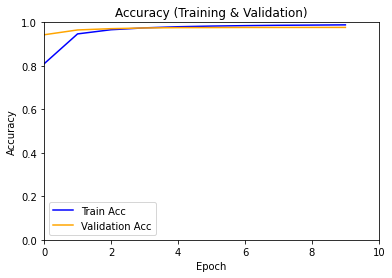

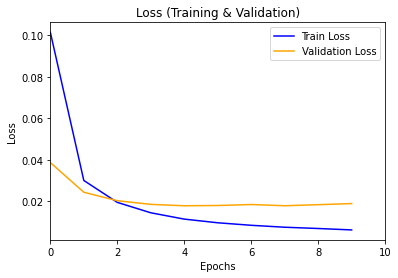

In [ ]:
# Entraîner le modèle à nouveau avec la meilleure combinaison d'Hyperparamètres déduites ci-dessus:

"""
===[ SUMMARY ]===
Best TRIAL: 30
	 Best Model Hyperparameters: {'num_epochs': 3, 'learning_rate': 0.01, 'embedding_dim': 100, 'hidden_dim': 300, 'num_layers': 2, 'batch_size': 512, 'bidirectional': True, 'dropout': 0.3}
	 Best Model Validation Accuracy with no Overfitting: 0.9726042724596767
	 Best Model Historical Metrics: {
     'train_loss': [0.15355524130654138, 0.04472520354619353, 0.029718464570471455], 
     'train_acc': [0.851137463124301, 0.9554420881827527, 0.970918568544086], 
     'valid_loss': [0.047724062442405325, 0.034087105466746107, 0.030782170443011778], 
     'valid_acc': [0.9542888127657377, 0.9683696830943487, 0.9726042724596767], 
     'best_valid_acc_wo_overfitting': 0.9726042724596767}
"""

mydata_file_path = "/content/gdrive/My Drive/Colab Notebooks/NLP/data/brown.postag.dataset.p"

# ===[HYPER PARAMETERS]===
NUM_EPOCHS = 10
LEARNING_RATE = 0.01
EMBEDDING_DIM = 100
HIDDEN_DIM = 300
NUM_LAYERS = 2
BATCH_SIZE = 512
BIDRECTIONAL = True
DROPOUT = 0.3
STEMMING = False
DISPLAY_GRAPHS = True
DEVICE = get_device()

# ===[PARAMETERS]===
DEBUG_MODE = False


# Get datasets and dataloaders
mydata_dataset, (train_dataset, train_dataloader), (valid_dataset, valid_dataloader), (test_dataset, test_dataloader) = get_dataloaders(mydata_file_path, STEMMING, batch_size=BATCH_SIZE, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1)

# Run and show results
best_model, hyperparameters, metrics_history = runner_visualizer(
    num_epochs=NUM_EPOCHS, 
    train_dataloader=train_dataloader, 
    learning_rate=LEARNING_RATE, 
    valid_dataloader=valid_dataloader, 
    embedding_dim=EMBEDDING_DIM, 
    hidden_dim=HIDDEN_DIM, 
    vocab_size=len(mydata_dataset.w2i),  # Words Vocabulary size
    tagset_size=len(mydata_dataset.t2i), # Tags Vocabulary size
    num_layers=NUM_LAYERS, 
    batch_size=BATCH_SIZE, 
    bidirectional=BIDRECTIONAL, 
    dropout=DROPOUT,
    display_graphs=DISPLAY_GRAPHS,
    debug_mode=DEBUG_MODE)

In [ ]:
# Prédiction de Tags sur des phrases "normalement" jamais vues

#model.load_state_dict(torch.load('best-model.pt'))

test_loss, test_acc = evaluate(best_model, test_dataloader)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}')

Test Loss: 0.017 | Test Acc: 0.98


## **ANNEXE A): Fine Tuning Hyperparameters: RAY**

In [ ]:
## If you are running on Google Colab, uncomment below to install the necessary dependencies 
## before beginning the exercise.

print("Setting up colab environment")
!pip uninstall -y -q pyarrow
!pip install -q https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-0.8.0.dev5-cp36-cp36m-manylinux1_x86_64.whl
!pip install -q ray[debug]

In [ ]:
# # A hack to force the runtime to restart, needed to include the above dependencies.
# print("Done installing! Restarting via forced crash.")
#import os
#os._exit(0)

"""
#!pip install ray
!pip install -U ray
!pip install 'ray[tune]'
!pip install tensorboardX
"""

import ray
print("ray version: ", ray.__version__)

In [ ]:
# # If you are running on Google Colab, please install TensorFlow 2.0 by uncommenting below..
try:
  %tensorflow_version only exists in Colab.
  #%tensorflow_version 2.x
except Exception:
  pass

In [ ]:
import tensorflow as tf
try:
    tf.get_logger().setLevel('INFO')
except Exception as exc:
    print(exc)
import warnings
warnings.simplefilter("ignore")

import numpy as np

import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets

import ray
from ray import tune
from ray.tune import track
from ray.tune.schedulers import AsyncHyperBandScheduler

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("ggplot")

In [ ]:
# ===[HYPER PARAMETERS]===
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
NUM_LAYERS = 2
BATCH_SIZE = 128
BIDRECTIONAL = True
DROPOUT = 0.2
STEMMING = False


# ===[PARAMETERS]===
DEBUG_MODE = False
print_every = 1

#==============================================================================
def train_bilstm(config):

    # Get datasets and dataloaders
    mydata_dataset, (train_dataset, train_dataloader), (valid_dataset, valid_dataloader), (test_dataset, test_dataloader) = get_dataloaders(mydata_file_path, STEMMING, batch_size=BATCH_SIZE, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1)


    # ===[MODEL, LOSS, OPTIMIZER]===
    model = BrownTagger(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, vocab_size=len(mydata_dataset.w2i), tagset_size=len(mydata_dataset.t2i)
              , num_layers=NUM_LAYERS
              , batch_size=BATCH_SIZE
              , bidirectional=BIDRECTIONAL
              , dropout=DROPOUT
              , debug_mode=DEBUG_MODE
            ).to(DEVICE)

    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    for i in range(1):
        #train(model, optimizer, train_loader, DEVICE)
        #test_acc = test(model, test_loader, DEVICE)

        train_loss, train_acc = train(model, train_dataloader, optimizer)
        valid_loss, valid_acc = evaluate(model, valid_dataloader)

        #tune.track.log(train_loss=train_loss, train_acc=train_acc, test_loss=test_loss, test_acc=test_acc)
        #tune.report(train_loss=train_loss, train_acc=train_acc, test_loss=test_loss, test_acc=test_acc)
        tune.report(mean_accuracy=valid_acc)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model, "./model.pth")
#==============================================================================
np.random.seed(1)

search_space = {
    "lr": tune.loguniform(0.001, 0.01)
}

ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)




analysis = tune.run(
    train_bilstm, 
    config=search_space, 
    verbose=2,
    name="train_bilstm",  # This is used to specify the logging directory.
    stop={"mean_accuracy": 0.95}  # This will stop the trial 
)

In [ ]:
!cat /root/ray_results/train_bilstm/train_bilstm_08cb5d06_2020-07-05_14-37-211vncnayx/error_2020-07-05_14-37-25.txt

In [ ]:
def train_bilstm(config):
    
    model = BrownTagger(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, vocab_size=VOCAB_SIZE, tagset_size=TAGSET_SIZE
              , num_layers=NUM_LAYERS
              , batch_size=BATCH_SIZE
              , bidirectional=BIDRECTIONAL
              , dropout=DROPOUT
              , debug_mode=DEBUG_MODE
            ).to(DEVICE)
    
    train_loader, test_loader = train_dataloader, test_dataloader
    
    optimizer = optim.Adam(
        model.parameters(), 
        lr=config["lr"])
    
    for i in range(3):
        train(model, optimizer, train_loader, DEVICE)
        test_acc = test(model, test_loader, DEVICE)

        #tune.track.log(train_loss=train_loss, train_acc=train_acc, test_loss=test_loss, test_acc=test_acc)
        #tune.report(train_loss=train_loss, train_acc=train_acc, test_loss=test_loss, test_acc=test_acc)
        tune.report(mean_accuracy=test_acc)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model, "./model.pth")


search_space = {
    "lr": tune.choice([0.001, 0.01, 0.1])
}



analysis = tune.run(
    train_bilstm, 
    config=search_space, 
    name="use_gpu",  # This is used to specify the logging directory.
    verbose=2)

In [ ]:
!cat /root/ray_results/train_bilstm/train_bilstm_0_lr=0.0017826_2020-07-05_14-09-29dlgkes6p/error.txt


In [ ]:
dfs = analysis.trial_dataframes

# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /root/ray_results/train_bilstm

In [ ]:
from ray.tune.schedulers import ASHAScheduler

analysis = tune.run(
    train_bilstm,
    num_samples=30,
    scheduler=ASHAScheduler(metric="mean_accuracy", mode="max", grace_period=1),
    config=search_space,
    resources_per_trial={'gpu': 1})

## **ANNEXE B): Fine Tuning Hyperparameters: HypOpt**

In [ ]:
!pip install hypopt

In [ ]:
from hypopt import GridSearch

In [ ]:
param_grid = {
    'learning_rate': [0.001, 0.01]
}



# ===[HYPER PARAMETERS]===
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
NUM_LAYERS = 2
BATCH_SIZE = 128
BIDRECTIONAL = True
DROPOUT = 0.2
STEMMING = False


# ===[PARAMETERS]===
DEBUG_MODE = False
print_every = 1

# Get datasets and dataloaders
mydata_dataset, (train_dataset, train_dataloader), (valid_dataset, valid_dataloader), (test_dataset, test_dataloader) = get_dataloaders(mydata_file_path, STEMMING, batch_size=BATCH_SIZE, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1)


# ===[MODEL, LOSS, OPTIMIZER]===
model = BrownTagger(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, vocab_size=len(mydata_dataset.w2i), tagset_size=len(mydata_dataset.t2i)
          , num_layers=NUM_LAYERS
          , batch_size=BATCH_SIZE
          , bidirectional=BIDRECTIONAL
          , dropout=DROPOUT
          , debug_mode=DEBUG_MODE
        ).to(DEVICE)

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#train_loss, train_acc = train(model, train_dataloader, optimizer)
#valid_loss, valid_acc = evaluate(model, valid_dataloader)

In [ ]:
gs_val = GridSearch(model = model, param_grid=param_grid)

gs_val.fit()

#%time gs_val.fit(X_train, y_train, param_grid, X_val, y_val)

print("Grid-search using a validation set.\n","-"*79)

#test_score = round(gs_val.score(X_test, y_test), 4)
#val_score = round(gs_val.score(X_val, y_val), 4)

#print('\nTEST SCORE (hyper-parameter optimization with validation set):', test_score)
#print('VALIDATION SCORE (hyper-parameter optimization with validation set):', val_score)